<a href="https://colab.research.google.com/github/Irina-Bogdanova-bioinformatician/BI_ML_2023/blob/kaggle_competition/kaggle_dota/kaggle_dota.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 14.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score

%matplotlib inline
%config InlineBackend.figure_format='svg'

# Загрузка и EDA

In [ ]:
%%bash

unzip test_data.csv.zip
unzip train_data.csv.zip
unzip train_targets.csv.zip

Archive:  test_data.csv.zip
  inflating: test_data.csv           


In [ ]:
!unzip test_raw_data.jsonl.zip
!unzip train_raw_data.jsonl.zip

Archive:  test_raw_data.jsonl.zip
  inflating: test_raw_data.jsonl     
Archive:  train_raw_data.jsonl.zip
  inflating: train_raw_data.jsonl    


In [ ]:
import json

with open('/content/test_raw_data.jsonl') as test_raw, open('/content/train_raw_data.jsonl') as train_raw:
    json_train = train_raw.read()
    json_test = train_raw.read()
  
# json_train = json.loads(json_train)      Error!
# json_test = json.loads(json_test)        Error!

In [ ]:
train_df = pd.read_csv("train_data.csv")
train_target = pd.read_csv("train_targets.csv")
test_df = pd.read_csv("test_data.csv")
train_df.head(10)

,match_id_hash,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,...,0.000000,0,0,0,0,0.000000,0,0,0,0
1,6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,...,0.000000,0,0,0,0,0.000000,0,0,0,0
2,19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,...,0.000000,0,0,0,0,0.000000,0,0,0,0
3,c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,...,8.264696,0,0,3,0,0.250000,0,0,3,0
4,156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,...,15.762911,3,1,0,1,0.500000,0,0,3,0
5,df50f738c454d430a33b2bf90cb9ef1a,636,22,7,1,5,74,1,1,0,...,8.064697,0,0,1,0,0.428571,0,0,1,0
6,7469e9440ea3d19b211a484647c7126e,1054,22,0,8,5,71,1,3,10,...,2.899237,0,0,11,0,0.636364,0,0,0,0
7,0aa1c6d7630433a93fe42da5ac810368,1797,22,7,9,2,35,1,5,2,...,34.424866,0,0,19,0,0.371429,0,0,0,0
8,892b5d40992e4b334e159f99b2bb55e6,605,22,7,0,5,30,0,1,3,...,0.000012,0,0,3,0,0.250000,0,0,1,0
9,44eb0c077ca68678bb9bfead29e9c455,1514,22,7,6,3,26,2,6,6,...,0.000000,0,0,7,1,0.518518,2,0,0,0


In [ ]:
train_df.describe()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
count,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,...,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000,31698.000000
mean,1146.519496,19.583538,4.771563,6.535239,7.358982,51.081614,3.151713,3.273361,4.661998,6.255600,...,11.773022,1.021957,0.338381,4.697363,0.088965,0.416247,0.299640,0.024449,1.255568,0.780933
std,766.936655,6.306635,3.260899,6.486933,13.295763,34.573173,3.727116,3.281208,5.207887,8.144267,...,20.400131,3.427767,0.946140,4.662255,0.284697,0.267604,0.730835,0.172030,2.582681,2.436478
min,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,-3.294393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,521.000000,22.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.235294,0.000000,0.000000,0.000000,0.000000
50%,1044.000000,22.000000,7.000000,4.000000,3.000000,44.000000,2.000000,2.000000,3.000000,3.000000,...,1.532971,0.000000,0.000000,3.000000,0.000000,0.444444,0.000000,0.000000,0.000000,0.000000
75%,1659.000000,22.000000,7.000000,10.000000,9.000000,81.000000,5.000000,5.000000,7.000000,9.000000,...,16.129388,0.000000,0.000000,7.000000,0.000000,0.600000,0.000000,0.000000,1.000000,0.000000
max,4933.000000,23.000000,7.000000,43.000000,291.000000,120.000000,32.000000,27.000000,40.000000,83.000000,...,222.612630,107.000000,29.000000,57.000000,1.000000,2.000000,9.000000,5.000000,26.000000,47.000000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31698 entries, 0 to 31697
Columns: 246 entries, match_id_hash to d5_sen_placed
dtypes: float64(30), int64(215), object(1)
memory usage: 59.5+ MB


In [ ]:
train_df.columns.tolist()

['match_id_hash',
 'game_time',
 'game_mode',
 'lobby_type',
 'objectives_len',
 'chat_len',
 'r1_hero_id',
 'r1_kills',
 'r1_deaths',
 'r1_assists',
 'r1_denies',
 'r1_gold',
 'r1_lh',
 'r1_xp',
 'r1_health',
 'r1_max_health',
 'r1_max_mana',
 'r1_level',
 'r1_x',
 'r1_y',
 'r1_stuns',
 'r1_creeps_stacked',
 'r1_camps_stacked',
 'r1_rune_pickups',
 'r1_firstblood_claimed',
 'r1_teamfight_participation',
 'r1_towers_killed',
 'r1_roshans_killed',
 'r1_obs_placed',
 'r1_sen_placed',
 'r2_hero_id',
 'r2_kills',
 'r2_deaths',
 'r2_assists',
 'r2_denies',
 'r2_gold',
 'r2_lh',
 'r2_xp',
 'r2_health',
 'r2_max_health',
 'r2_max_mana',
 'r2_level',
 'r2_x',
 'r2_y',
 'r2_stuns',
 'r2_creeps_stacked',
 'r2_camps_stacked',
 'r2_rune_pickups',
 'r2_firstblood_claimed',
 'r2_teamfight_participation',
 'r2_towers_killed',
 'r2_roshans_killed',
 'r2_obs_placed',
 'r2_sen_placed',
 'r3_hero_id',
 'r3_kills',
 'r3_deaths',
 'r3_assists',
 'r3_denies',
 'r3_gold',
 'r3_lh',
 'r3_xp',
 'r3_health',
 '

In [ ]:
object_features = train_df.select_dtypes(include='object').columns.tolist()
print(object_features)

['match_id_hash']


In [ ]:
train_df.shape

(31698, 246)

In [ ]:
train_target.shape

(31698, 6)

In [ ]:
train_target.head

<bound method NDFrame.head of                           match_id_hash  game_time  radiant_win  duration  \
0      b9c57c450ce74a2af79c9ce96fac144d        658         True      1154   
1      6db558535151ea18ca70a6892197db41         21         True      1503   
2      19c39fe2af2b547e48708ca005c6ae74        160        False      2063   
3      c96d629dc0c39f0c616d1949938a6ba6       1016         True      2147   
4      156c88bff4e9c4668b0f53df3d870f1b        582        False      1927   
...                                 ...        ...          ...       ...   
31693  b794aa55646841a03c7783226e6f6bc8       2666        False      2701   
31694  308faee28efee2e66b39f9f2ba6ea9cf       2525         True      3358   
31695  6066cc7417b43c749d551e123d00f0c8       1002         True      2217   
31696  bc7a87ed5f9c2bca55f9f7a93da0b0c5        377         True      3107   
31697  e2ca68ac1a6847f4a37f6c9c8ee8695b        643        False      1804   

       time_remaining next_roshan_team  
0   

In [ ]:
train_target_only = train_target[["radiant_win"]]
train_target_only.head

<bound method NDFrame.head of        radiant_win
0             True
1             True
2            False
3             True
4            False
...            ...
31693        False
31694         True
31695         True
31696         True
31697        False

[31698 rows x 1 columns]>

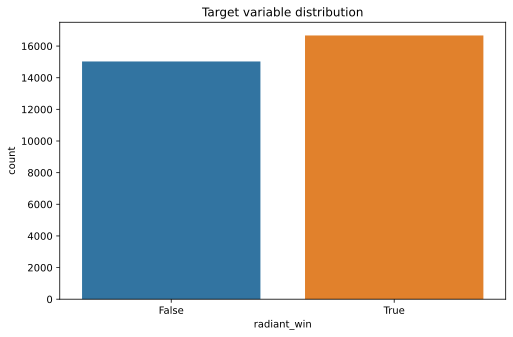

In [ ]:
# Посмотрим распределение целевой переменной

plt.figure(figsize=(8, 5))
sns.countplot(x="radiant_win", data=train_target)
plt.title('Target variable distribution')
plt.show()

## Обработка выбросов

In [ ]:
def outliers_number(df_in, param_name):
    q1 = df_in[param_name].quantile(0.25)
    q3 = df_in[param_name].quantile(0.75)
    iqr = q3 - q1
    boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
    outliers = df_in[param_name].loc[(df_in[param_name] < boxplot_range[0]) | (df_in[param_name] > boxplot_range[1])]
    n = len(outliers)
    return n   


def remove_outlier(df_in, params_names):
    for param_name in params_names:
        q1 = df_in[param_name].quantile(0.25)
        q3 = df_in[param_name].quantile(0.75)
        iqr = q3 - q1
        boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
        changed_data = df_in.loc[(df_in[param_name] >= boxplot_range[0]) & (df_in[param_name] <= boxplot_range[1])]
    return changed_data


def outliers_to_median(df_in, params_names):
    for param_name in params_names:
        q1 = df_in[param_name].quantile(0.25)
        q3 = df_in[param_name].quantile(0.75)
        iqr = q3 - q1
        boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
        new_condition = (df_in[param_name] < boxplot_range[0]) | (df_in[param_name] > boxplot_range[1])
        feature_median = df_in[param_name].median()
        df_in.loc[new_condition, param_name] = feature_median
    return df_in
  
    
def outliers_to_mean(df_in, params_names):
    for param_name in params_names:
        q1 = df_in[param_name].quantile(0.25)
        q3 = df_in[param_name].quantile(0.75)
        iqr = q3 - q1
        boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
        new_condition = (df_in[param_name] < boxplot_range[0]) | (df_in[param_name] > boxplot_range[1])
        condition_mean = (df_in[param_name] >= boxplot_range[0]) | (df_in[param_name] <= boxplot_range[1])
        feature_mean = df_in[param_name].mean()
        df_in.loc[new_condition, param_name] = feature_mean
    return df_in


def outliers_clip(df_in, params_names):
    for param_name in params_names:
        q1 = df_in[param_name].quantile(0.25)
        q3 = df_in[param_name].quantile(0.75)
        iqr = q3 - q1
        boxplot_range = [q1 - 1.5 * iqr, q3 + 1.5 * iqr]
        condition_1 = (df_in[param_name] < boxplot_range[0]) 
        condition_2 = (df_in[param_name] > boxplot_range[1])
        df_in.loc[condition_1, param_name] = boxplot_range[0]
        df_in.loc[condition_1, param_name] = boxplot_range[1]
    return df_in


In [ ]:
quantative_features = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
for el in quantative_features:
    print(f"Количество выбросов для признака {el}: {outliers_number(train_df, el)}")

Количество выбросов для признака game_time: 191
Количество выбросов для признака game_mode: 6374
Количество выбросов для признака lobby_type: 0
Количество выбросов для признака objectives_len: 674
Количество выбросов для признака chat_len: 2575
Количество выбросов для признака r1_hero_id: 0
Количество выбросов для признака r1_kills: 943
Количество выбросов для признака r1_deaths: 750
Количество выбросов для признака r1_assists: 1231
Количество выбросов для признака r1_denies: 1929
Количество выбросов для признака r1_gold: 999
Количество выбросов для признака r1_lh: 1779
Количество выбросов для признака r1_xp: 206
Количество выбросов для признака r1_health: 863
Количество выбросов для признака r1_max_health: 784
Количество выбросов для признака r1_max_mana: 1305
Количество выбросов для признака r1_level: 0
Количество выбросов для признака r1_x: 0
Количество выбросов для признака r1_y: 0
Количество выбросов для признака r1_stuns: 2775
Количество выбросов для признака r1_creeps_stacked: 5

Создали функцию outliers_number, расчитывающую количество выбросов, которая принимает выборку, а возвращает число выбросов, а также функцию outliers_to_median, заменяющюю выбросы на медианы. Функция outliers_to_median принимает датасет и название признака, по которому определяются выбросы. Концы усов boxplot рассчитываем как разность первого квартиля и полутора межквартильных расстояний и сумму третьего квартиля и полутора межквартильных расстояний соответственно.
Также создали функции remove_outlier, удаляющую выбросы, функцию outliers_clip, которая действует как np.clip, 
и функцию outliers_to_mean, заменяющую выбросы на средние значения.
    
Оставим выбросы без изменений.

## Обработка пропусков

In [ ]:
# Посмотрим, по каким признакам есть пропуски и сколько их

def get_nan_info(df):
    nan_dict = {}
    for i in df.columns:
        nan_values = df[i].isna().sum()
        if nan_values != 0:
            nan_dict[i] = nan_values
    print(nan_dict)
            

get_nan_info(train_df)

{}


## Анализ признакового пространства

In [ ]:
train_df.shape

(31698, 246)

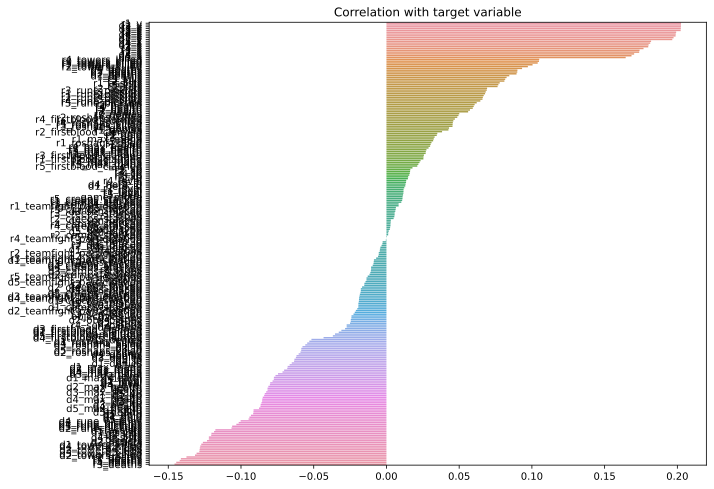

In [ ]:
# Корреляция с целевой переменной

features = train_df.columns.tolist()
concatenated = train_df.copy()
concatenated["target"] = train_target_only

corr_with_target = concatenated[features + ["target"]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [ ]:
matrix = train_df.corr()
print("Correlation matrix is : ")
print(matrix)

Correlation matrix is : 
                            game_time  game_mode  lobby_type  objectives_len  \
game_time                    1.000000  -0.013263    0.057378        0.886073   
game_mode                   -0.013263   1.000000    0.353861        0.004395   
lobby_type                   0.057378   0.353861    1.000000        0.014690   
objectives_len               0.886073   0.004395    0.014690        1.000000   
chat_len                     0.283910   0.005311    0.011804        0.281166   
...                               ...        ...         ...             ...   
d5_teamfight_participation   0.330493   0.010808    0.044376        0.280463   
d5_towers_killed             0.390061  -0.002994    0.012943        0.413313   
d5_roshans_killed            0.204402  -0.008178    0.014456        0.233635   
d5_obs_placed                0.332175   0.026224    0.066734        0.299340   
d5_sen_placed                0.303428   0.038678    0.065137        0.288331   

              

## Генерация признаков

Среда перезапускается при попытках работать с файлами json, содержащими сырые данные с дополнительными фичами.

## Разбиение на train и test

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df[quantative_features], train_target["radiant_win"], test_size=0.3,shuffle=True, random_state=42)

## Построение модели

In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**RandomForestClassifier**

С помощью GridSearchCV для RandomForestClassifier найдем оптимальные значения параметров n_estimators, max_depth, max_features.

In [ ]:
max_depths = [None] + list(np.arange(3, 21))

In [ ]:
parameters = [{'n_estimators': [50, 100, 250, 300, 350, 400, 450, 500], 
               'max_depth': max_depths}]
clf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=parameters, cv=5)
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': None, 'n_estimators': 500}

In [ ]:
clf = RandomForestClassifier(n_estimators=500, random_state=42)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_valid_pred = clf.predict(X_valid)
RA_valid = roc_auc_score(y_valid, y_valid_pred)
RA_train = roc_auc_score(y_train, y_train_pred)
print(f"ROC AUC для тренировочной выборки: {RA_train}.\nROC AUC для тестовой выборки: {RA_valid}")

ROC AUC для тренировочной выборки: 1.0.
ROC AUC для тестовой выборки: 0.6964306653719559


In [ ]:
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     10440
        True       1.00      1.00      1.00     11748

    accuracy                           1.00     22188
   macro avg       1.00      1.00      1.00     22188
weighted avg       1.00      1.00      1.00     22188

TEST

              precision    recall  f1-score   support

       False       0.74      0.58      0.65      4588
        True       0.68      0.81      0.74      4922

    accuracy                           0.70      9510
   macro avg       0.71      0.70      0.69      9510
weighted avg       0.71      0.70      0.70      9510

CONFUSION MATRIX

col_0        False  True
radiant_win             
False         2674  1914
True           935  3987


In [ ]:
# кросс-валидация

cv_score = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=KFold(n_splits=3, shuffle=True, random_state=42))
print(f"cv_score: {cv_score}, cv_score.mean():{cv_score.mean()}")

cv_score: [0.78657936 0.78902746 0.78149683], cv_score.mean():0.7857012203588954


In [ ]:
# Оценим важность признаков

feature_importances = pd.DataFrame(zip(X_train.columns, clf.feature_importances_), columns=['feature_name', 'importance'])
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature_name,importance
18,r1_y,0.013012
90,r4_y,0.012427
42,r2_y,0.012112
65,r3_x,0.011836
66,r3_y,0.011763
...,...,...
26,r1_roshans_killed,0.000154
146,d1_roshans_killed,0.000152
170,d2_roshans_killed,0.000148
218,d4_roshans_killed,0.000144


In [ ]:
not_important = feature_importances['feature_name'][feature_importances['importance'] < 0.001]
list(not_important)

['r1_creeps_stacked',
 'd5_camps_stacked',
 'r2_towers_killed',
 'd2_camps_stacked',
 'd4_camps_stacked',
 'd3_camps_stacked',
 'd1_camps_stacked',
 'r4_camps_stacked',
 'r3_camps_stacked',
 'r5_camps_stacked',
 'r2_camps_stacked',
 'r1_camps_stacked',
 'lobby_type',
 'r4_firstblood_claimed',
 'd4_firstblood_claimed',
 'r1_firstblood_claimed',
 'd5_firstblood_claimed',
 'd3_firstblood_claimed',
 'r3_firstblood_claimed',
 'd1_firstblood_claimed',
 'd2_firstblood_claimed',
 'r2_firstblood_claimed',
 'r5_firstblood_claimed',
 'r2_roshans_killed',
 'd3_roshans_killed',
 'r5_roshans_killed',
 'r3_roshans_killed',
 'r4_roshans_killed',
 'r1_roshans_killed',
 'd1_roshans_killed',
 'd2_roshans_killed',
 'd4_roshans_killed',
 'd5_roshans_killed']

In [ ]:
train_df_preprocessed = train_df.copy().drop(not_important, axis = 1)

In [ ]:
quantative_features_2 = train_df_preprocessed.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [ ]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(train_df_preprocessed[quantative_features_2], train_target["radiant_win"], test_size=0.3,shuffle=True, random_state=42)

In [ ]:
clf_2 = RandomForestClassifier(n_estimators=500, random_state=42)
clf_2.fit(X_train_, y_train_)
y_train_pred_clf2 = clf_2.predict(X_train_)
y_valid_pred_clf2 = clf_2.predict(X_valid_)
RA_valid_clf2 = roc_auc_score(y_valid_, y_valid_pred_clf2)
RA_train_clf2 = roc_auc_score(y_train_, y_train_pred_clf2)
print(f"ROC AUC для тренировочной выборки: {RA_train_clf2}.\nROC AUC для тестовой выборки: {RA_valid_clf2}")

ROC AUC для тренировочной выборки: 1.0.
ROC AUC для тестовой выборки: 0.6958083150327321


In [ ]:
get_classification_report(y_train_, y_train_pred_clf2, y_valid_, y_valid_pred_clf2)

TRAIN

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     10440
        True       1.00      1.00      1.00     11748

    accuracy                           1.00     22188
   macro avg       1.00      1.00      1.00     22188
weighted avg       1.00      1.00      1.00     22188

TEST

              precision    recall  f1-score   support

       False       0.74      0.59      0.65      4588
        True       0.68      0.81      0.74      4922

    accuracy                           0.70      9510
   macro avg       0.71      0.70      0.69      9510
weighted avg       0.71      0.70      0.70      9510

CONFUSION MATRIX

col_0        False  True
radiant_win             
False         2686  1902
True           954  3968


**CatBoost**

In [ ]:
model_catb = CatBoostClassifier(silent=True, random_state=42)
model_catb.fit(X_train, y_train)

y_train_pred_2 = model_catb.predict(X_train)
y_valid_pred_2 = model_catb.predict(X_valid)

In [ ]:
y_train_pred_2 = np.array([x == 'True' for x in y_train_pred_2])
y_valid_pred_2 = np.array([x == 'True' for x in y_valid_pred_2])

In [ ]:
RA_valid_2 = roc_auc_score(y_valid, y_valid_pred_2)
RA_train_2 = roc_auc_score(y_train, y_train_pred_2)
print(f"ROC AUC для тренировочной выборки: {RA_train_2}.\nROC AUC для тестовой выборки: {RA_valid_2}")

ROC AUC для тренировочной выборки: 0.8686368724047919.
ROC AUC для тестовой выборки: 0.7076400567244835


In [ ]:
get_classification_report(y_train, y_train_pred_2, y_valid, y_valid_pred_2)

TRAIN

              precision    recall  f1-score   support

       False       0.89      0.83      0.86     10440
        True       0.86      0.91      0.88     11748

    accuracy                           0.87     22188
   macro avg       0.87      0.87      0.87     22188
weighted avg       0.87      0.87      0.87     22188

TEST

              precision    recall  f1-score   support

       False       0.73      0.64      0.68      4588
        True       0.70      0.78      0.74      4922

    accuracy                           0.71      9510
   macro avg       0.71      0.71      0.71      9510
weighted avg       0.71      0.71      0.71      9510

CONFUSION MATRIX

col_0        False  True
radiant_win             
False         2926  1662
True          1095  3827


In [ ]:
# Подбор гиперпараметров для model_catb

model_catb = CatBoostClassifier(silent=True, random_state=42)

params = {'n_estimators':[10, 25, 50, 100, 200, 500],
          'max_depth':[3, 5, 7, 10, 15]}

cv=KFold(n_splits=3, random_state=42, shuffle=True)

rs = RandomizedSearchCV(model_catb, params, scoring='roc_auc', cv=cv, n_jobs=-1)

rs.fit(X_train, y_train)

rs.best_params_

{'n_estimators': 500, 'max_depth': 3}

In [ ]:
model_catb_final = CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=42)
model_catb_final.fit(X_train, y_train)

y_train_pred_catb = model_catb_final.predict(X_train)
y_valid_pred_catb = model_catb_final.predict(X_valid)

y_train_pred_catb = np.array([x == 'True' for x in y_train_pred_catb])
y_valid_pred_catb = np.array([x == 'True' for x in y_valid_pred_catb])

get_classification_report(y_train, y_train_pred_catb, y_valid, y_valid_pred_catb)

TRAIN

              precision    recall  f1-score   support

       False       0.77      0.68      0.72     10440
        True       0.74      0.82      0.78     11748

    accuracy                           0.75     22188
   macro avg       0.76      0.75      0.75     22188
weighted avg       0.76      0.75      0.75     22188

TEST

              precision    recall  f1-score   support

       False       0.73      0.62      0.67      4588
        True       0.69      0.78      0.73      4922

    accuracy                           0.70      9510
   macro avg       0.71      0.70      0.70      9510
weighted avg       0.71      0.70      0.70      9510

CONFUSION MATRIX

col_0        False  True
radiant_win             
False         2834  1754
True          1064  3858


In [ ]:
RA_valid_catb = roc_auc_score(y_valid, y_valid_pred_catb)
RA_train_catb = roc_auc_score(y_train, y_train_pred_catb)
print(f"ROC AUC для тренировочной выборки: {RA_train_catb}.\nROC AUC для тестовой выборки: {RA_valid_catb}")

ROC AUC для тренировочной выборки: 0.7497461049863219.
ROC AUC для тестовой выборки: 0.7007630279084318


#### Прогнозирование на тестовом датасете

In [ ]:
submit_prediction = model_catb_final.predict(test_df[quantative_features])
test_df['radiant_win_prob'] = np.array([x == 'True' for x in submit_prediction])
test_df[["match_id_hash", "radiant_win_prob"]]

,match_id_hash,radiant_win_prob
0,a400b8f29dece5f4d266f49f1ae2e98a,False
1,46a0ddce8f7ed2a8d9bd5edcbb925682,True
2,b1b35ff97723d9b7ade1c9c3cf48f770,False
3,ab3cc6ccac661a1385e73a2e9f21313a,True
4,54aaab1cb8cc5df3c253641618673266,True
...,...,...
7972,03f683fed8cf6f03b735e2ee2a942698,True
7973,06e2b42495855647830ccc6d466f913c,False
7974,defd0caeed6ea83d7d5fbdec013fe7d1,False
7975,47ad6454ede66c1c78fdaa9391dfc556,True


In [ ]:
test_df[["match_id_hash", "radiant_win_prob"]].to_csv('submit.csv', index=False)

**Light auto ML**

In [ ]:
!pip install lightautoml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.6/319.6 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.2/465.2 kB 47.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.7/215.7 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.1/804.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2

In [ ]:
!pip install torch==2.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 10.2 MB/s eta 0:00:00
     ━━━━━

In [ ]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.tasks.common_metric import mean_quantile_error

In [ ]:
X_y_train = X_train.copy()
X_y_train["target"] = y_train

In [ ]:
TASK = Task("binary", metric="auc", greater_is_better=False)
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42
TEST_SIZE = 0.3
TARGET_NAME = "target"
roles = {"target": TARGET_NAME, "drop": ["match_id_hash"]}


In [ ]:
automl_model = TabularAutoML(task=TASK,
                            timeout=30000,
                            cpu_limit = N_THREADS,
                            gpu_ids='all',
                            reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                            general_params={'use_algos': [['lgb_tuned', 'cb_tuned', 'cb'],['lgb_tuned', 'cb']]},
                            tuning_params={'max_tuning_iter': 20},
                      )

In [ ]:
train_pred_automl = automl_model.fit_predict(X_y_train, roles = roles, verbose = 1)

[15:33:32] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[15:33:32] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


[15:33:32] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[15:33:32] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[15:33:32] - time: 30000.00 seconds


INFO:lightautoml.automl.presets.base:- time: 30000.00 seconds


[15:33:32] - CPU: 8 cores


INFO:lightautoml.automl.presets.base:- CPU: 8 cores


[15:33:32] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[15:33:32] Train data shape: (22188, 246)



INFO:lightautoml.reader.base:Train data shape: (22188, 246)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[15:33:50] Layer 1 train process start. Time left 29981.92 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 29981.92 secs
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.779649
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.792598
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.798915
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.799557
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.79889
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.800136
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.800802
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.801004
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.801622
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.801647
DEBUG:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.801435
DEBUG:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.801913
DEBUG:lightautoml.ml_algo.boost_lgbm:

[15:35:23] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[15:35:26] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-c37a3e18-ca7e-417a-ae9b-25923e8b3107
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.780933
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.792321
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.797481
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.799384
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.80142
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.802237
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.802535
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.802946
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.802911
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc:

[15:41:52] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.8659969709057025, 'num_leaves': 159}
 achieve -0.8041 auc


[15:41:52] Start fitting Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 159, 'feature_fraction': 0.8659969709057025, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.789317
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.794058
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.797483
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.797675
DEBUG:lightautoml

[15:46:53] Fitting Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM finished. score = -0.8015504065581555


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM finished. score = -0.8015504065581555


[15:46:53] Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM fitting and predicting completed


[15:46:53] Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'GPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 5000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'devices': '0'}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====
Default metric period is 5 because AUC is/are not implemented for GPU
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6537209	best: 0.6537209 (0)	total: 25.9ms	remaining: 2m 9s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7699827	best: 0.7699827 (100)	total: 669ms	remainin

[15:47:55] Fitting Lvl_0_Pipe_0_Mod_1_CatBoost finished. score = -0.798316653229962


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_1_CatBoost finished. score = -0.798316653229962


[15:47:55] Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed


[15:47:55] Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_2_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_0_Mod_2_Tuned_CatBoost ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-3b0a445d-f7ac-411c-951b-ed72fd767fb4
Default metric period is 5 because AUC is/are not implemented for GPU
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6531342	best: 0.6531342 (0)	total: 5.6ms	remaining: 28s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7669343	best: 0.7669343 (100)	total: 451ms	remaining: 21.9s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7796258	best: 0.7796258 (200)	total: 907ms	remaining: 21.7s
DEBUG:lightautoml.ml_algo.boost_cb:300:	test: 0.7861741	best: 0.7861741 (300)	total: 1.36s	remaining: 21.2s
DEBUG:lightautoml.ml_algo.boost_cb:400:	test: 0.7906664	best: 0.7906664 (400)	total: 1.82s	remaining: 20.9s
DEBUG:lightautoml.ml_algo.boost_cb:500:	test: 0.7931485	best: 0.7931890 (495)	total: 2.29s	remaining: 20.5s
DEBUG:lightautoml.ml_algo.b

[15:51:37] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_2_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_0_Mod_2_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 7}
 achieve -0.7947 auc


[15:51:37] Start fitting Lvl_0_Pipe_0_Mod_2_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_2_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'GPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'devices': '0'}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_2_Tuned_CatBoost =====
Default metric period is 5 because AUC is/are not implemented for GPU
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6674248	best: 0.6674248 (0)	total: 8.54ms	remaining: 25.6s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7787020	best: 0.7787020 (100)	total: 78

[15:52:21] Fitting Lvl_0_Pipe_0_Mod_2_Tuned_CatBoost finished. score = -0.7916598667809438


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_2_Tuned_CatBoost finished. score = -0.7916598667809438


[15:52:21] Lvl_0_Pipe_0_Mod_2_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_2_Tuned_CatBoost fitting and predicting completed


[15:52:21] Time left 28870.96 secs



INFO:lightautoml.automl.base:Time left 28870.96 secs



[15:52:21] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[15:52:21] Layer 2 train process start. Time left 28870.91 secs


INFO:lightautoml.automl.base:Layer 2 train process start. Time left 28870.91 secs


[15:52:23] Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-ba9f8ef5-97db-4439-a49d-5a192d366563
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.780933
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.792321
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.797481
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.799384
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.80142
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.802237
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.802535
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.802946
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.802911
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc:

[15:58:22] Hyperparameters optimization for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.8659969709057025, 'num_leaves': 159}
 achieve -0.8041 auc


[15:58:22] Start fitting Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 159, 'feature_fraction': 0.8659969709057025, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.789317
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.794058
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.797483
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.797675
DEBUG:lightautoml

[16:03:30] Fitting Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM finished. score = -0.8015504065581555


INFO:lightautoml.ml_algo.base:Fitting Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM finished. score = -0.8015504065581555


[16:03:30] Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM fitting and predicting completed


[16:03:30] Start fitting Lvl_1_Pipe_0_Mod_1_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_1_Pipe_0_Mod_1_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'GPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 5000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'devices': '0'}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_1_CatBoost =====
Default metric period is 5 because AUC is/are not implemented for GPU
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6537209	best: 0.6537209 (0)	total: 8.71ms	remaining: 43.5s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7699919	best: 0.7699919 (100)	total: 657ms	remainin

[16:04:22] Fitting Lvl_1_Pipe_0_Mod_1_CatBoost finished. score = -0.7988974034220547


INFO:lightautoml.ml_algo.base:Fitting Lvl_1_Pipe_0_Mod_1_CatBoost finished. score = -0.7988974034220547


[16:04:22] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


[16:04:22] Time left 28149.77 secs



INFO:lightautoml.automl.base:Time left 28149.77 secs



[16:04:22] Layer 2 training completed.



INFO:lightautoml.automl.base:Layer 2 training completed.



[16:04:22] Blending: optimization starts with equal weights and score -0.8045335751287902


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -0.8045335751287902


[16:04:22] Blending: iteration 0: score = -0.7988974034220547, weights = [0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -0.7988974034220547, weights = [0. 1.]


[16:04:23] Blending: iteration 1: score = -0.7988974034220547, weights = [0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -0.7988974034220547, weights = [0. 1.]


[16:04:23] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[16:04:23] Automl preset training completed in 1850.44 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 1850.44 seconds



[16:04:23] Model description:
Models on level 0:
	 5 averaged models Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM
	 5 averaged models Lvl_0_Pipe_0_Mod_1_CatBoost
	 5 averaged models Lvl_0_Pipe_0_Mod_2_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (5 averaged models Lvl_1_Pipe_0_Mod_1_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Models on level 0:
	 5 averaged models Lvl_0_Pipe_0_Mod_0_Tuned_LightGBM
	 5 averaged models Lvl_0_Pipe_0_Mod_1_CatBoost
	 5 averaged models Lvl_0_Pipe_0_Mod_2_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (5 averaged models Lvl_1_Pipe_0_Mod_1_CatBoost) 



In [ ]:
valid_pred_automl = automl_model.predict(X_valid)
valid_pred_automl

array([[0.5808208 ],
       [0.6233927 ],
       [0.5556127 ],
       ...,
       [0.88990676],
       [0.9831792 ],
       [0.4351571 ]], dtype=float32)

In [ ]:
valid_pred_automl_ = np.array([x.data[0] > 0.5 for x in valid_pred_automl])
valid_pred_automl_


array([ True,  True,  True, ...,  True,  True, False])

In [ ]:
train_pred_automl_ = np.array([x.data[0] > 0.5 for x in train_pred_automl])
train_pred_automl_

array([ True, False,  True, ...,  True,  True, False])

In [ ]:
RA_valid_automl = roc_auc_score(y_valid, valid_pred_automl_)
RA_train_automl = roc_auc_score(y_train, train_pred_automl_)
print(f"ROC AUC для тренировочной выборки: {RA_train_automl}.\nROC AUC для тестовой выборки: {RA_valid_automl}")

ROC AUC для тренировочной выборки: 0.7127631898215006.
ROC AUC для тестовой выборки: 0.7061474167014139


#### Прогнозирование на тестовом датасете

In [ ]:
submit_prediction_2 = automl_model.predict(test_df[quantative_features])
test_df['radiant_win_prob'] = np.array([x.data[0] for x in submit_prediction_2])
test_df.head

<bound method NDFrame.head of                          match_id_hash  game_time  game_mode  lobby_type  \
0     a400b8f29dece5f4d266f49f1ae2e98a        155         22           7   
1     46a0ddce8f7ed2a8d9bd5edcbb925682        576         22           7   
2     b1b35ff97723d9b7ade1c9c3cf48f770        453         22           7   
3     ab3cc6ccac661a1385e73a2e9f21313a        721          4           0   
4     54aaab1cb8cc5df3c253641618673266        752         22           7   
...                                ...        ...        ...         ...   
7972  03f683fed8cf6f03b735e2ee2a942698        509          4           0   
7973  06e2b42495855647830ccc6d466f913c       2561         22           7   
7974  defd0caeed6ea83d7d5fbdec013fe7d1       1783         22           0   
7975  47ad6454ede66c1c78fdaa9391dfc556       2405         22           7   
7976  9928dfde50efcbdb2055da23dcdbc101       1775         22           0   

      objectives_len  chat_len  r1_hero_id  r1_kills  r1_

In [ ]:
test_df.shape

(7977, 247)

In [ ]:
test_df[["match_id_hash", "radiant_win_prob"]].to_csv('submit_2.csv', index=False)